In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score

In [2]:
attrition=pd.read_csv('Employee_Attrition.csv')
attrition

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


In [3]:
attrition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

## Data preprocessing

In [4]:
X,y=attrition.drop(columns=['Attrition'],axis=1),attrition.Attrition

In [5]:
cat_cols=X.select_dtypes('object').columns.values
for col in cat_cols:
    print(f'{attrition[col].value_counts(normalize=True)}\n')

BusinessTravel
Travel_Rarely        0.709524
Travel_Frequently    0.188435
Non-Travel           0.102041
Name: proportion, dtype: float64

Department
Research & Development    0.653741
Sales                     0.303401
Human Resources           0.042857
Name: proportion, dtype: float64

EducationField
Life Sciences       0.412245
Medical             0.315646
Marketing           0.108163
Technical Degree    0.089796
Other               0.055782
Human Resources     0.018367
Name: proportion, dtype: float64

Gender
Male      0.6
Female    0.4
Name: proportion, dtype: float64

JobRole
Sales Executive              0.221769
Research Scientist           0.198639
Laboratory Technician        0.176190
Manufacturing Director       0.098639
Healthcare Representative    0.089116
Manager                      0.069388
Sales Representative         0.056463
Research Director            0.054422
Human Resources              0.035374
Name: proportion, dtype: float64

MaritalStatus
Married     0.457823


In [6]:
X=X.drop(columns=['Over18','EmployeeCount','EmployeeNumber'],axis=1)

In [7]:
# create dummies
cat_cols=X.select_dtypes('object').columns.values.tolist()
num_cols=X.select_dtypes('number').columns.values

for col in num_cols:
    if X[col].nunique()<=5:
        cat_cols.append(col)
cat_df=X.copy()[cat_cols]
for col in cat_cols:
    temp_dummy=pd.get_dummies(X[col],drop_first=True,prefix=col)
    cat_df.drop(columns=col,axis=1,inplace=True)
    cat_df=pd.concat([cat_df,temp_dummy],axis=1)
dummy_cols=cat_df.columns.values
for col in dummy_cols:
    if cat_df[col].mean()<=0.05:
        cat_df.drop(columns=col,axis=1,inplace=True)
cat_df=cat_df.astype('int64')
cat_df

,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,...,PerformanceRating_4,RelationshipSatisfaction_2,RelationshipSatisfaction_3,RelationshipSatisfaction_4,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3,WorkLifeBalance_2,WorkLifeBalance_3,WorkLifeBalance_4
0,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0,1,...,1,0,0,1,1,0,0,0,1,0
2,0,1,1,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,1,0
3,1,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,1,1,0,0,0,1,0,0,1,...,0,0,0,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,1,0,1,0,0,0,1,0,0,1,...,0,0,1,0,1,0,0,0,1,0
1466,0,1,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,1,0
1467,0,1,1,0,1,0,0,0,0,1,...,1,1,0,0,1,0,0,0,1,0
1468,1,0,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,1,0,0


In [8]:
cols_to_drop=[]
num_df=X.copy().drop(columns=cat_cols,axis=1)
num_df_std=pd.DataFrame(data=preprocessing.normalize(num_df),
                        columns=num_df.columns.values)
for col in num_df_std.columns.values:
    if num_df_std[col].std()<=1e-10:
        cols_to_drop.append(col)
num_df.drop(columns=cols_to_drop,axis=1,inplace=True)
X=pd.concat([num_df,cat_df],axis=1)
y=y.map({'Yes':1,'No':0})

## Feature selection through feature importance

In [9]:
X_train,X_test,y_train,y_test=train_test_split(X,
                                               y,
                                               test_size=0.3,
                                               shuffle=True,
                                               stratify=y,
                                               random_state=42)
scaler=MinMaxScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [10]:
model=GradientBoostingClassifier(random_state=42)
cv_score=cross_val_score(estimator=model,
                X=X_train_scaled,
                y=y_train,
                scoring='roc_auc',
                cv=10,
                n_jobs=-1).mean()
model.fit(X=X_train_scaled,
          y=y_train)
test_score=roc_auc_score(y_true=y_test,
              y_score=model.predict_proba(X_test_scaled)[:,-1])
print(f'Train score: {cv_score}')
print(f'Test score: {test_score}')

Train score: 0.7920323482239728
Test score: 0.7735059002664637


In [11]:
feature_importance_df=pd.DataFrame()
feature_importance_df['Features']=X.columns.values
feature_importance_df['Importance']=model.feature_importances_
feature_importance_df=feature_importance_df.sort_values(by=['Importance'],
                                  ascending=False)
feature_importance_df['Cumulative_importance']=feature_importance_df.Importance.cumsum()
feature_importance_df.reset_index(inplace=True,
                                  drop=True)
selected_features=feature_importance_df[feature_importance_df.Cumulative_importance<=0.95].Features.values

## Classification to predict the attrition

In [12]:
X=X.copy()[selected_features]
X_train,X_test,y_train,y_test=train_test_split(X,
                                               y,
                                               test_size=0.3,
                                               shuffle=True,
                                               stratify=y,
                                               random_state=42)
scaler=MinMaxScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [13]:
# Random forest model
rfc=RandomForestClassifier(random_state=42,
                           class_weight='balanced')
cv_score=cross_val_score(estimator=rfc,
                        X=X_train_scaled,
                        y=y_train,
                        scoring='roc_auc',
                        cv=10,
                        n_jobs=-1).mean()
rfc.fit(X=X_train_scaled,
        y=y_train)
test_score=rfc.score(X=X_test_scaled,
                     y=y_test)
print(f'Cross val score = {cv_score}')
print(f'Test score = {test_score}')
print(f'Score diff = {abs(cv_score-test_score)}')

Cross val score = 0.7943613692469771
Test score = 0.8367346938775511
Score diff = 0.04237332463057397


In [14]:
# Gradient boosting model
class_weights={1:1/y.mean(),0:(1/(1-y.mean()))}
sample_weights=np.where(y_train==1,class_weights[1],class_weights[0])
gbc=GradientBoostingClassifier(random_state=42)
cv_score=cross_val_score(estimator=gbc,
                         X=X_train_scaled,
                         y=y_train,
                         scoring='roc_auc',
                         cv=10,
                         n_jobs=-1,
                         fit_params={'sample_weight': sample_weights}).mean()
gbc.fit(X=X_train_scaled,
        y=y_train,
        sample_weight=sample_weights)
test_score=gbc.score(X=X_test_scaled,
                     y=y_test)
print(f'Cross val score = {cv_score}')
print(f'Test score = {test_score}')
print(f'Score diff = {abs(cv_score-test_score)}')

Cross val score = 0.789591834127396
Test score = 0.8117913832199547
Score diff = 0.022199549092558724


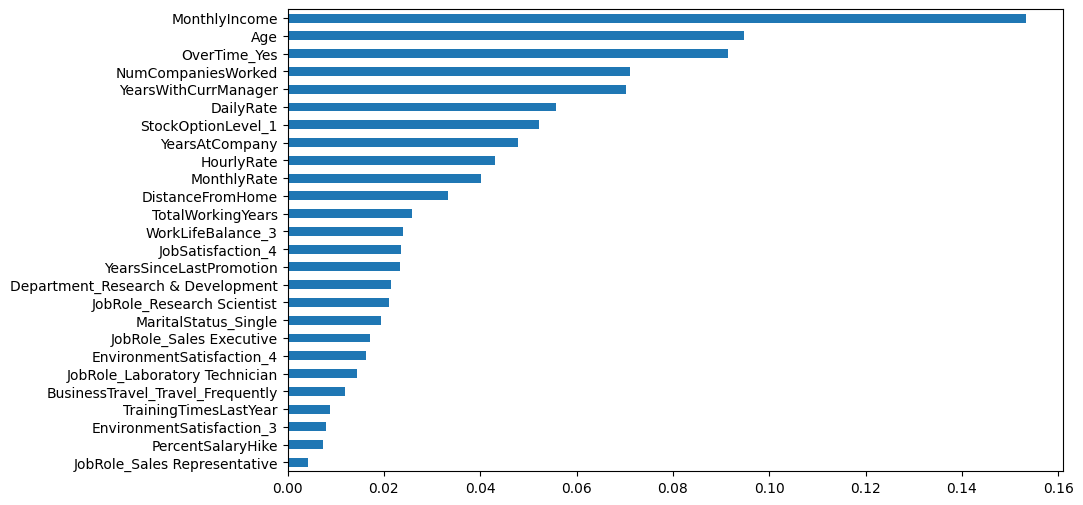

In [15]:
## Final model is the Gradient Boosting model
feature_importance=pd.Series(data=gbc.feature_importances_,
                             index=X.columns.values).sort_values()
plt.figure(figsize=(10,6))
feature_importance.plot.barh();

In [16]:
cutoff_dict={}
cutoffs=np.linspace(start=0,stop=1,num=1000)
y_pred_prob=gbc.predict_proba(X=X_test_scaled)[:,-1]
for cutoff in cutoffs:
    y_pred=np.where(y_pred_prob>cutoff,1,0)
    rcl_score_0=recall_score(y_pred=y_pred,
                           y_true=y_test,
                           pos_label=0)
    rcl_score_1=recall_score(y_pred=y_pred,
                           y_true=y_test,
                           pos_label=1)
    cutoff_dict[cutoff]=abs(rcl_score_0-rcl_score_1)

optimal_cutoff=min(cutoff_dict,key=cutoff_dict.get)
y_pred=np.where(y_pred_prob>optimal_cutoff,1,0)
print(f'Best cutoff = {optimal_cutoff}\n')
print(classification_report(y_pred=y_pred,
                            y_true=y_test))

Best cutoff = 0.3253253253253253

              precision    recall  f1-score   support

           0       0.93      0.71      0.80       370
           1       0.32      0.70      0.44        71

    accuracy                           0.71       441
   macro avg       0.62      0.71      0.62       441
weighted avg       0.83      0.71      0.74       441

